# **Importing the Dependencies**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import shap

# **Loading the CSV File into the dataFrame**



In [ ]:
df = pd.read_csv('telco.csv')

In [ ]:
# Preview the first 5 rows

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Basic info about columns and datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Statistics Summary

df.describe()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,2283.300441,0.265370
std,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,2266.771362,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,401.450000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1397.475000,0.000000
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,3794.737500,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


In [ ]:
# Checking for missing values
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
df['Churn'].value_counts()


,count
Churn,
No,5174
Yes,1869


In [ ]:
df['Churn'].value_counts(normalize=True) * 100

,proportion
Churn,
No,73.463013
Yes,26.536987


In [ ]:
df.shape

(7043, 21)

# **Data Cleaning and Preprocessing**

In [ ]:
#customerID is irrelevant to prediction. hence removing the column from the datafrae

df.drop('customerID', axis=1, inplace=True)

In [ ]:
#TotalCharges is object but should be float. hence converting to float

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [ ]:
 #Encode Binary Columns
 #Yes = 1
 #No = 0

binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

In [ ]:
# Convert selected categorical columns into numerical dummy variables using one-hot encoding.
# This converts each category into a binary feature (0/1), and 'drop_first=True' avoids the dummy variable trap.

multi_cols = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
              'OnlineBackup', 'DeviceProtection', 'TechSupport',
              'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=multi_cols, drop_first=True)

In [ ]:
print(df.dtypes)

(7043, 31)
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
gender_Male                                 bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSuppo

In [ ]:
print(df.shape)

(7043, 31)


# **Training the Model**

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [ ]:
#Splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#training the model

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


In [ ]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:51:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Predicting

y_pred = model.predict(X_test)

In [ ]:
# Accuracy

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7721788502484032


In [ ]:
# Confusion Matrix

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[901 134]
 [187 187]]


In [ ]:
# Classification Report

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.50      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.69      1409
weighted avg       0.76      0.77      0.77      1409



# **Feature Importance Plot**

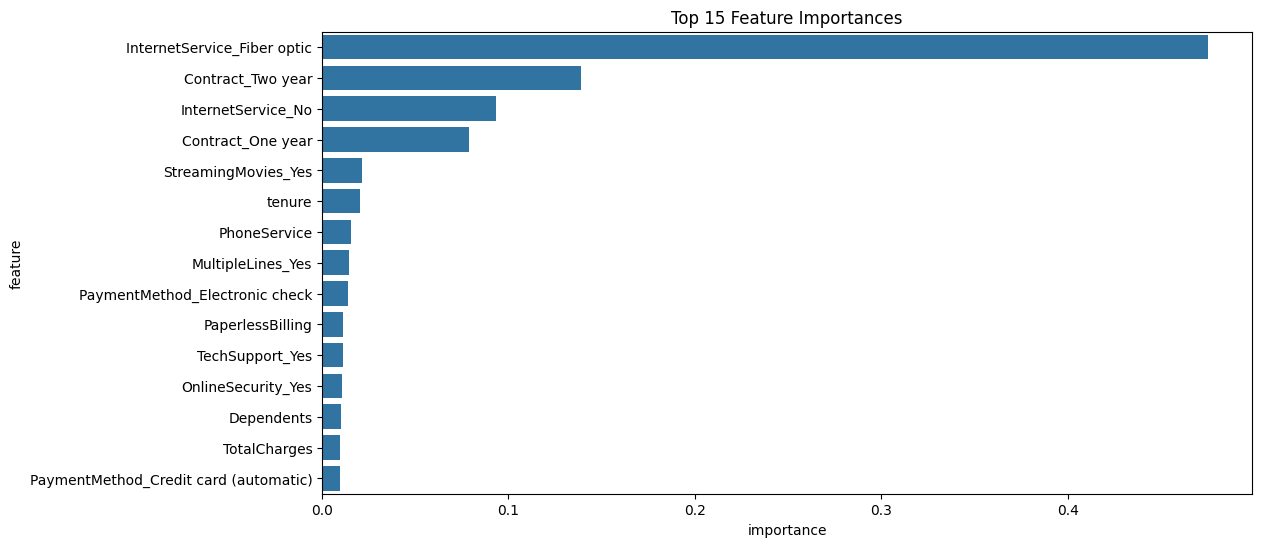

In [ ]:
importance = model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importance})
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title("Top 15 Feature Importances")plt.show()

# **Using SHAP to interpret the XGBoost Model**

In [ ]:
#initializing the explainer for the model

explainer = shap.TreeExplainer(model)

In [ ]:
#Computing SHAP values

shap_values = explainer.shap_values(X_test)

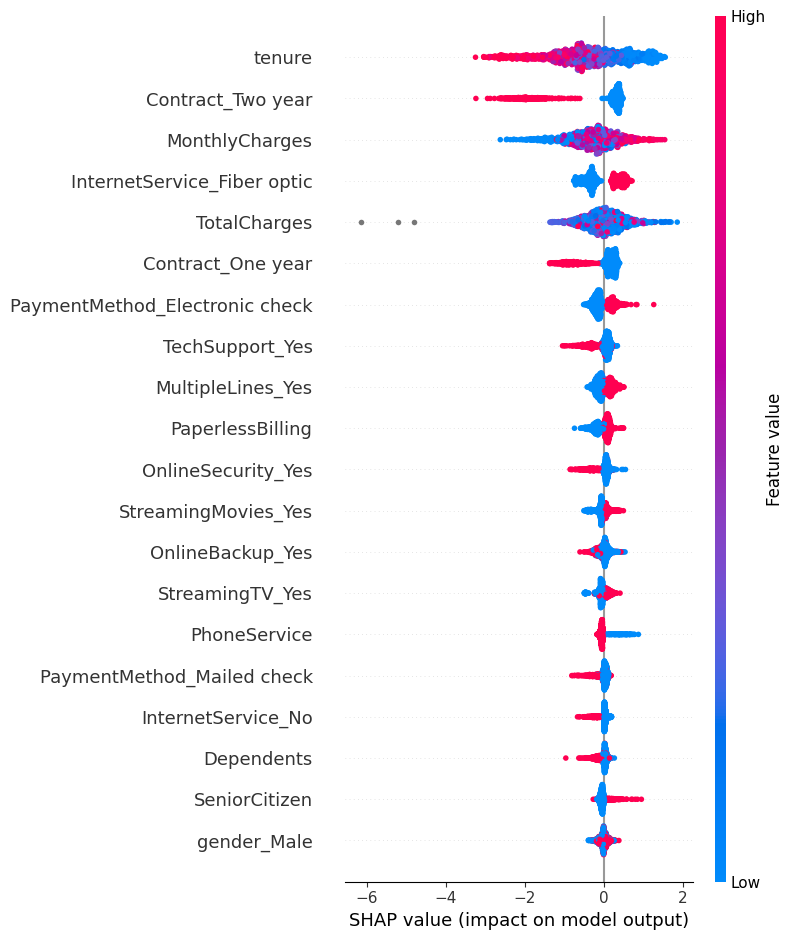

In [ ]:
#Summary plot - shows global feature importance

shap.summary_plot(shap_values, X_test)

In [ ]:
# Force plot for the first prediction

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])